# Image caption runs with various hyperparameters

### Time to get to loss 5.4 on DL

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [2]:
!ls logs/flextime/GTX_TITAN_X

loss5.4_100epoch loss5.8_20epoch  loss5.8_50epoch


In [3]:
logdir = "logs/flextime/GTX_TITAN_X/loss5.4_100epoch"

In [4]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

154

In [5]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))                
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1
        if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
        df_epochtime.loc[0] = [batch,learn,run,epoch,time,loss]
        
    return (df_epochtime, df_validation)

In [6]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [37]:
print logdir
df_epochtime,df_validation = readLogs(logdir)

logs/flextime/GTX_TITAN_X/loss5.4_100epoch


In [8]:
print df_validation.shape
print df_epochtime.shape
df_validation.head()

(154, 9)
(154, 6)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.170126,0.100507,0.066688,0.045706,0.211927,0.118072
1,12.0,0.0001,1.0,0.124676,0.070539,0.046297,0.031812,0.176895,0.098399
2,12.0,0.0005,0.0,0.375387,0.257774,0.180732,0.124017,0.353703,0.190473
3,12.0,0.0005,1.0,0.461636,0.315546,0.227375,0.165646,0.373390,0.238202
4,12.0,0.0010,0.0,0.502789,0.359879,0.269327,0.202449,0.400209,0.243514


## Validation score

In [9]:
print df_validation.shape
df_validation.head()

(154, 9)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12.0,0.0001,0.0,0.170126,0.100507,0.066688,0.045706,0.211927,0.118072
1,12.0,0.0001,1.0,0.124676,0.070539,0.046297,0.031812,0.176895,0.098399
2,12.0,0.0005,0.0,0.375387,0.257774,0.180732,0.124017,0.353703,0.190473
3,12.0,0.0005,1.0,0.461636,0.315546,0.227375,0.165646,0.373390,0.238202
4,12.0,0.0010,0.0,0.502789,0.359879,0.269327,0.202449,0.400209,0.243514


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b08dd0>]], dtype=object)

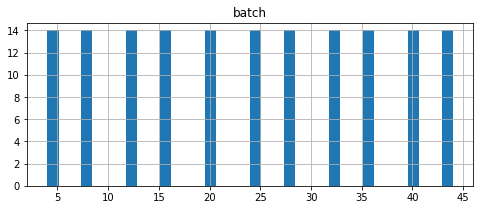

In [11]:
# Checking number of rows in the dataframe per batch size
# 7 LR values x 2 runs = 14 rows
plt.rcParams['figure.figsize'] = 8,3
df_validation[["batch"]].hist(bins=36)

In [12]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,4.0,0.0001,0.351809,0.236873,0.173085,0.127614,0.336978,0.143932
1,4.0,0.0005,0.436760,0.303316,0.228381,0.171066,0.363901,0.160624
2,4.0,0.0010,0.366834,0.252421,0.185520,0.140145,0.332546,0.121413
3,4.0,0.0025,0.391623,0.277781,0.211392,0.158878,0.339056,0.093828
4,4.0,0.0050,0.055313,0.023306,0.015866,0.011162,0.085771,0.006834


In [13]:
df_cider = df_mean.pivot_table(index="batch",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="lr",values="rouge")
df_blue1 = df_mean.pivot_table(index="batch",columns="lr",values="bleu1")
df_blue2 = df_mean.pivot_table(index="batch",columns="lr",values="bleu2")
df_blue3 = df_mean.pivot_table(index="batch",columns="lr",values="bleu3")
df_blue4 = df_mean.pivot_table(index="batch",columns="lr",values="bleu4")
df_cider.head()

lr,0.0001,0.0005,0.001,0.0025,0.005,0.0075,0.01
batch,,,,,,,
4.0,0.143932,0.160624,0.121413,0.093828,0.006834,0.002212,0.000886
8.0,0.110509,0.228459,0.204636,0.086797,0.078992,0.012884,0.003262
12.0,0.108236,0.214337,0.231201,0.191924,0.113659,0.039152,0.020683
16.0,0.093823,0.180148,0.192047,0.187258,0.115506,0.063563,0.035172
20.0,0.081908,0.213212,0.215864,0.209503,0.140649,0.062854,0.037907


In [14]:
def plotHeatMap(df,ax,title=None,cmap=None):        
    cmesh=ax.pcolormesh(df,cmap=cmap)
    fig.colorbar(mappable=cmesh,ax=ax)    
    ax.set_yticks(np.arange(0.5, len(df.index), 1))
    ax.set_yticklabels(df.index)
    ax.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax.set_xticklabels(df.columns)
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                ax.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.3, 'pad':0})
    ax.set_title(title,fontsize=18)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


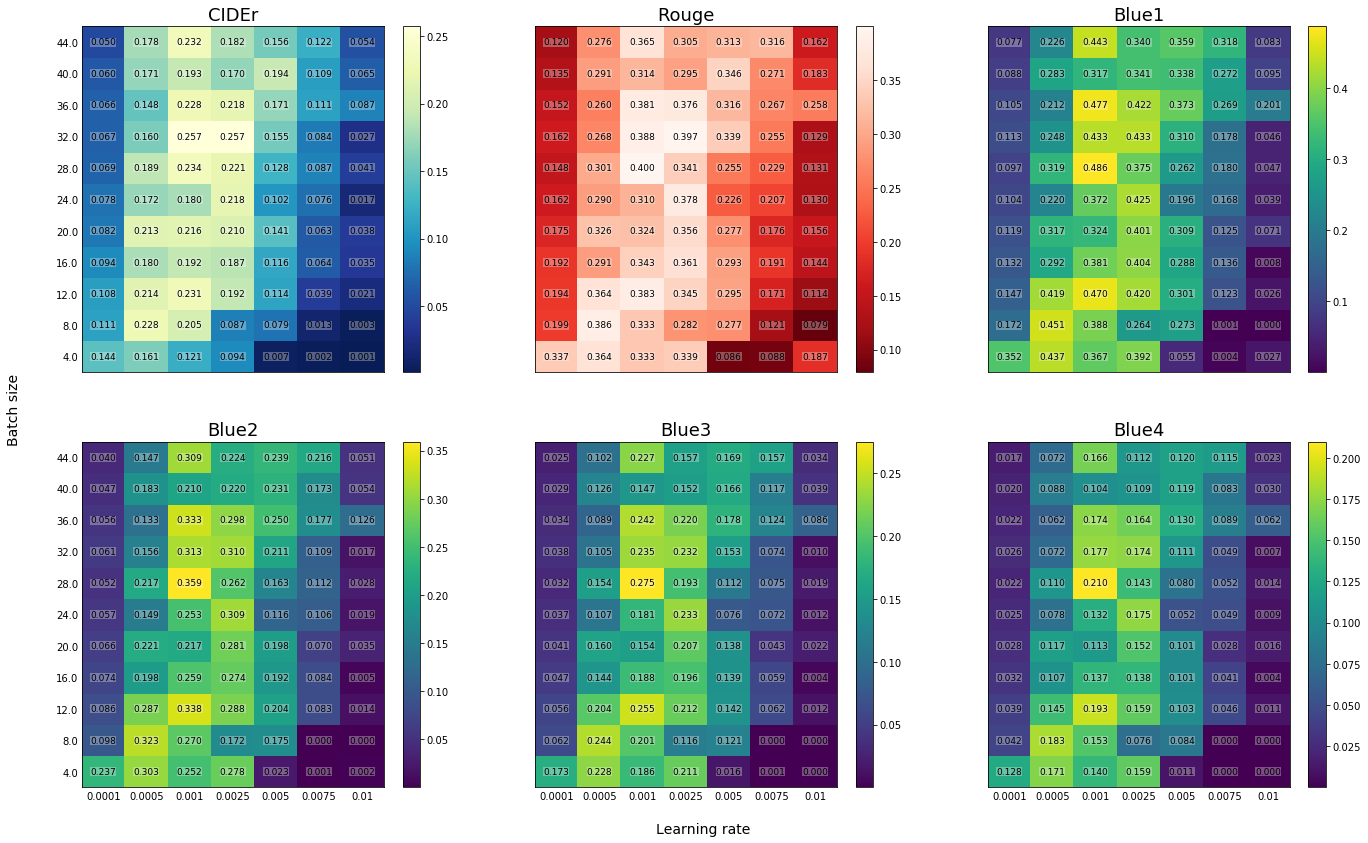

In [15]:
plt.rcParams['figure.figsize'] = 23,14
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
plotHeatMap(df_cider,ax[0,0],"CIDEr","YlGnBu_r")
plotHeatMap(df_rouge,ax[0,1],"Rouge","Reds_r")
plotHeatMap(df_blue1,ax[0,2],"Blue1")
plotHeatMap(df_blue2,ax[1,0],"Blue2")
plotHeatMap(df_blue3,ax[1,1],"Blue3")
plotHeatMap(df_blue4,ax[1,2],"Blue4")
fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch size', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and time

In [16]:
df_epochtime = df_epochtime[df_epochtime["batch"]!=2]
df_epochtime.head()

,batch,lr,run,epoch,time,loss
0,12.0,0.0001,0.0,100.0,1212.691628,5.832581
1,12.0,0.0001,1.0,100.0,1237.566612,5.915598
2,12.0,0.0005,0.0,72.0,882.428118,5.352497
3,12.0,0.0005,1.0,70.0,862.903073,5.298504
4,12.0,0.0010,0.0,68.0,833.870900,5.363052


In [17]:
# Take average between runs
df_mean = df_epochtime.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,epoch,time,loss
0,4.0,0.0001,93.0,1753.757159,5.644735
1,4.0,0.0005,52.0,985.874455,5.281868
2,4.0,0.0010,90.0,1699.155638,5.792793
3,4.0,0.0025,100.0,1880.643085,6.416791
4,4.0,0.0050,100.0,1892.957352,6.670568


In [18]:
loss_df = df_mean[['batch','lr','loss']]
time_df = df_mean[['batch','lr','time']]
epoch_df = df_mean[['batch','lr','epoch']]

In [19]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 10,8 
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [20]:
loss_T = loss_df.pivot_table(index="batch",columns="lr",values="loss")
time_T = time_df.pivot_table(index="batch",columns="lr",values="time")
epoch_T = epoch_df.pivot_table(index="batch",columns="lr",values="epoch")

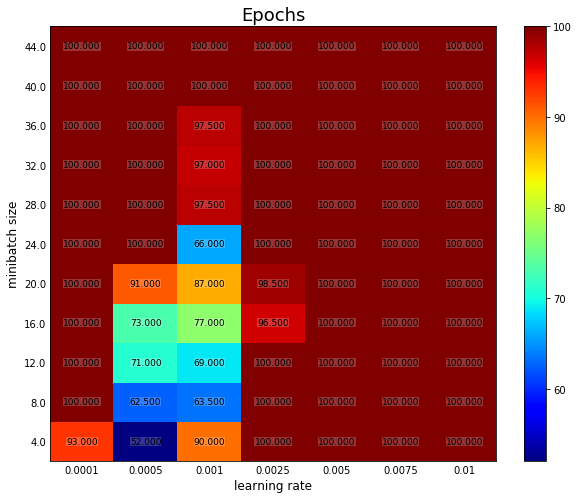

In [21]:
plotHeatMap(epoch_T,"Epochs","jet")

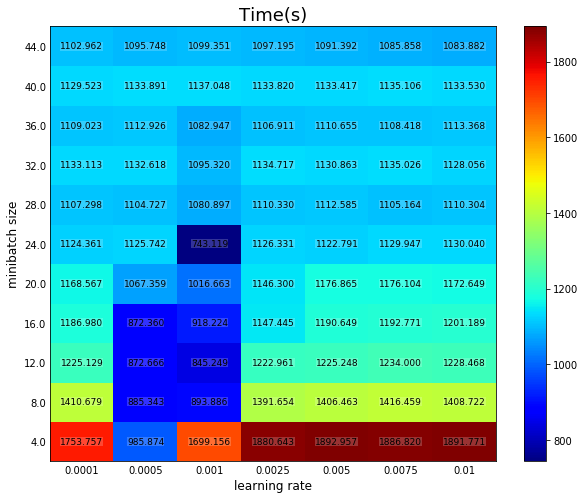

In [22]:
plotHeatMap(time_T,"Time(s)","jet")

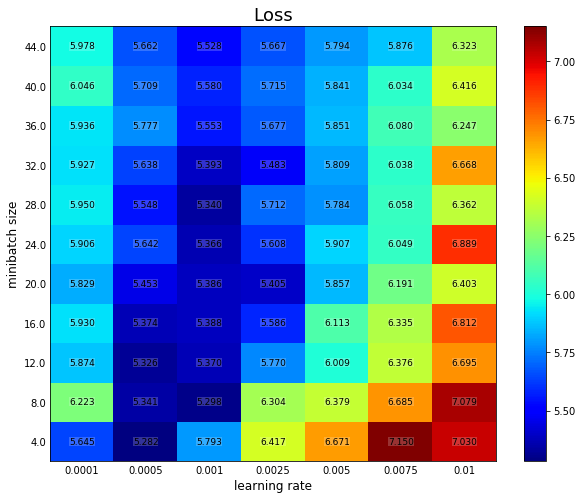

In [23]:
plotHeatMap(loss_T,"Loss","jet")

## Plot Loss graphs for each BS x LR combinations

In [24]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDFwEpochs(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0 # DataFrame row number (index)
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))                
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1
        
    return df_epochtime

In [25]:
def readEpochLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    
    filecounter=0
    for file in files:
        if debug: print file
        df_e1 = fileToDFwEpochs(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return df_epochtime

In [26]:
print logdir
df_epochtime = readEpochLogs(logdir)

logs/flextime/GTX_TITAN_X/loss5.4_100epoch


In [36]:
df_epochtime[(df_epochtime["batch"] == 4.) & (df_epochtime["lr"] == 0.001) & (df_epochtime["epoch"] > 79)]

,batch,lr,run,epoch,time,loss
12611,4.0,0.001,0.0,80.0,1515.700267,5.769437
12612,4.0,0.001,0.0,81.0,1534.777940,6.143118
12613,4.0,0.001,0.0,82.0,1553.790870,6.080151
12614,4.0,0.001,0.0,83.0,1572.943082,6.087868
12615,4.0,0.001,0.0,84.0,1591.790960,5.845665
12616,4.0,0.001,0.0,85.0,1610.817611,5.981332
12617,4.0,0.001,0.0,86.0,1629.668068,5.945535
12618,4.0,0.001,0.0,87.0,1648.632344,6.085023
12619,4.0,0.001,0.0,88.0,1667.728995,6.298296
12620,4.0,0.001,0.0,89.0,1686.740597,6.085338


In [33]:
# Take average between runs
df_mean_epo = df_epochtime.groupby(["batch","lr","epoch"]).mean().reset_index().drop(["run"],axis=1)
df_mean_epo[(df_mean_epo["batch"] == 4.) & (df_mean_epo["lr"] == 0.001)].tail()

,batch,lr,epoch,time,loss
263,4.0,0.001,96.0,1819.775524,5.787219
264,4.0,0.001,97.0,1839.005120,5.880938
265,4.0,0.001,98.0,1858.047730,6.176394
266,4.0,0.001,99.0,1877.309680,5.923194
267,4.0,0.001,100.0,1896.498947,6.307290


In [29]:
df_mean_epo = df_mean_epo.sort_values(by=["batch","lr","epoch"],ascending=True)
df_mean_epo.head(5)

,batch,lr,epoch,time,loss
0,4.0,0.0001,1.0,19.561318,7.036348
1,4.0,0.0001,2.0,38.582825,7.027807
2,4.0,0.0001,3.0,57.593015,6.640284
3,4.0,0.0001,4.0,76.501232,6.781705
4,4.0,0.0001,5.0,95.494872,6.691830


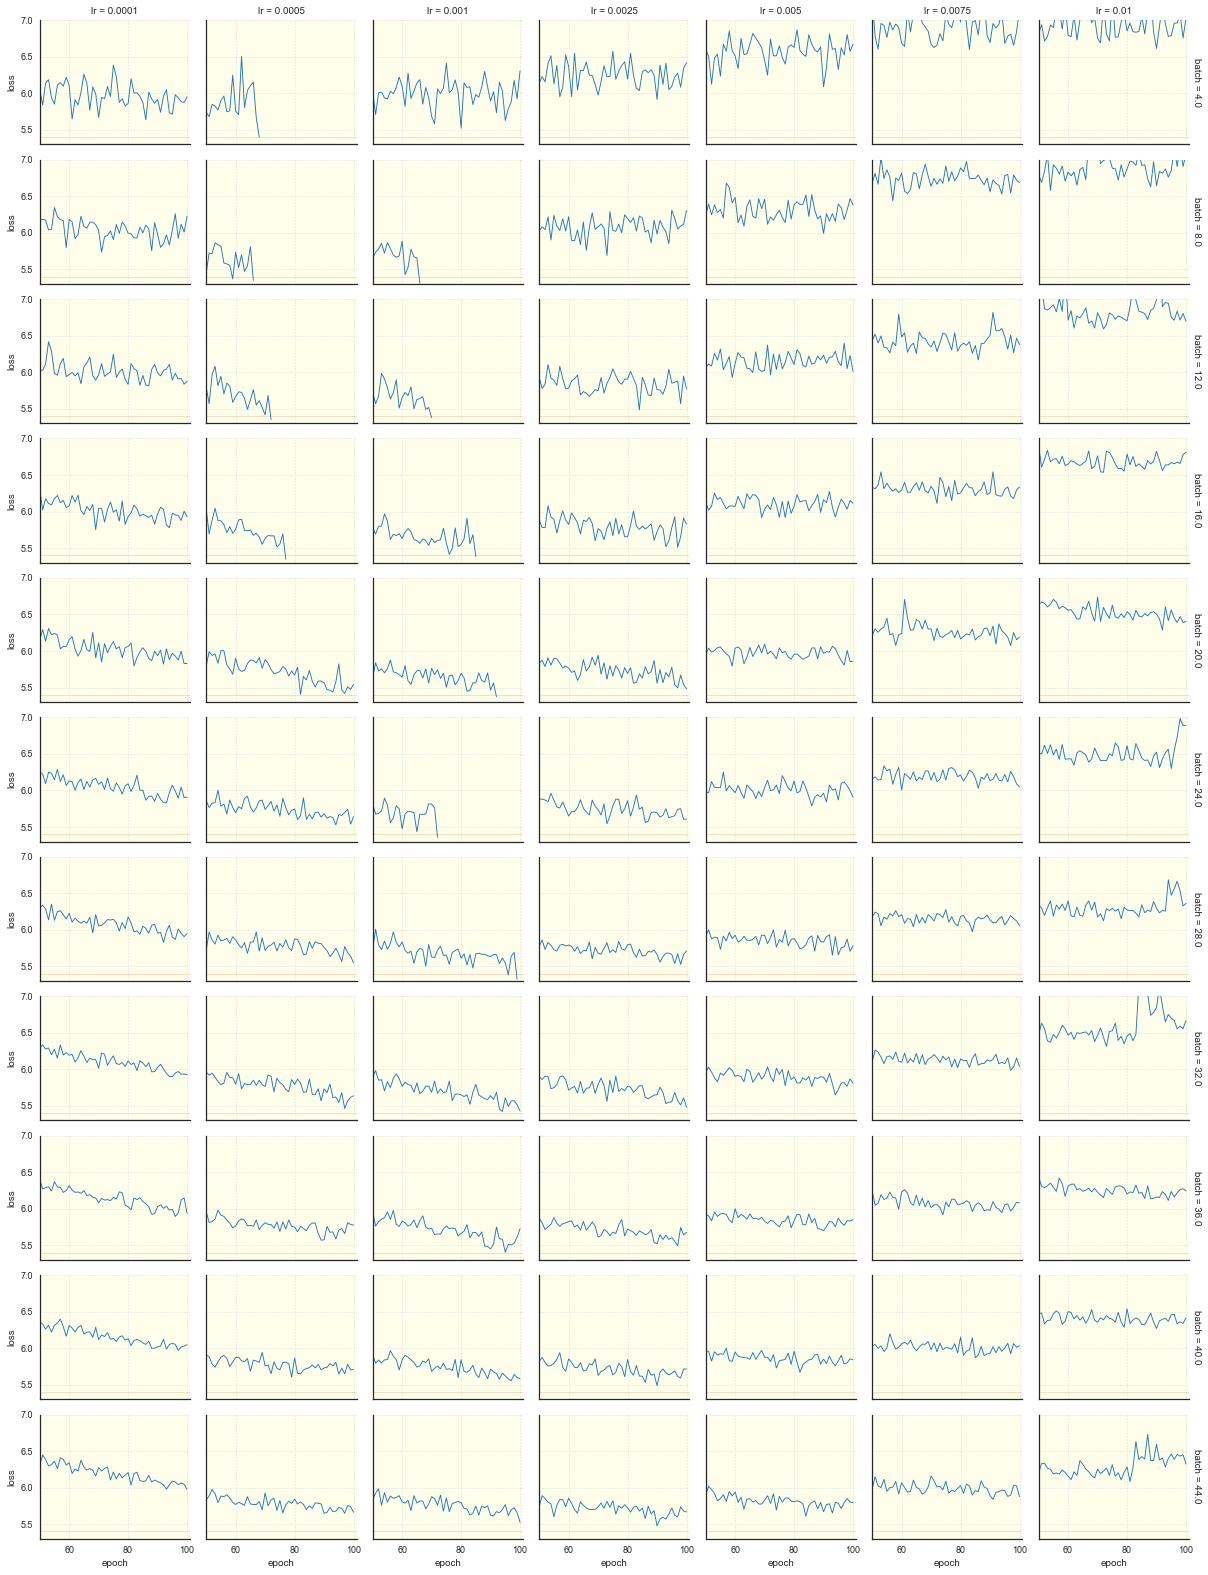

In [32]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=0.9)
sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
#print sns.axes_style()

# Plot using "tab10" matplotlib colormap
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_mean_epo,row="batch",col="lr",size=2,aspect=1.2,
                         #row_order=df_mean_epo.batch.unique(),
                         xlim=(50,101),
                         ylim=(5.3,7.),
                         margin_titles=True,
                         subplot_kws={"facecolor":"#FFFEEB"})
    fg.map(plt.axhline,y=5.4,ls="-",c="#ff8855",linewidth=1,alpha=.3)
    #fg.set(xticks=np.arange(50,101,10))
    #fg.set(yticks=np.arange(0.5,0.66,.05))
    fg.map(plt.grid,ls=":",alpha=.1,linewidth=1,aa=False)
    fg.map(plt.plot,"epoch","loss",ls="-",linewidth=.9)

